<a href="https://colab.research.google.com/github/ostannushka/bric-a-brac/blob/main/Ml_part_flights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine learning part

I decided to create a model for prediction of delay time. We already know that flight will be delayed, but should estimate duration of delay.
It's regression problem.
So first step is choose data for ML. Some columns contain data leakage, for example DEP_DELAY, TAXI_OUT, WHEELS_OFF, WHEELS_ON, TAXI_IN, CRS_ARR_TIME, ARR_TIME,  CRS_ELAPSED_TIME, ACTUAL_ELAPSED_TIME, AIR_TIME. 

In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [85]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from numpy.random import RandomState
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyRegressor
!pip install catboost
from catboost import CatBoostRegressor
!pip install lightgbm
import lightgbm as ltb


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [86]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [87]:
#datasets readcsv
try:
    df1 = pd.read_csv('/content/drive/MyDrive/aeroplanes/2014.csv')
except:
     df1 = pd.read_csv('2014.csv')   
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5819811 entries, 0 to 5819810
Data columns (total 28 columns):
 #   Column               Dtype  
---  ------               -----  
 0   FL_DATE              object 
 1   OP_CARRIER           object 
 2   OP_CARRIER_FL_NUM    int64  
 3   ORIGIN               object 
 4   DEST                 object 
 5   CRS_DEP_TIME         int64  
 6   DEP_TIME             float64
 7   DEP_DELAY            float64
 8   TAXI_OUT             float64
 9   WHEELS_OFF           float64
 10  WHEELS_ON            float64
 11  TAXI_IN              float64
 12  CRS_ARR_TIME         int64  
 13  ARR_TIME             float64
 14  ARR_DELAY            float64
 15  CANCELLED            float64
 16  CANCELLATION_CODE    object 
 17  DIVERTED             float64
 18  CRS_ELAPSED_TIME     float64
 19  ACTUAL_ELAPSED_TIME  float64
 20  AIR_TIME             float64
 21  DISTANCE             float64
 22  CARRIER_DELAY        float64
 23  WEATHER_DELAY        float64
 24

To prevent data leakage and to create some additional features we can work with reasons of delay, but there is too much missings

In [88]:
#we are interested only in delayed flights
# 
def only_delayed(df):
    df_del = df.loc[(df['ARR_DELAY'] > 0)]
    useful_columns = ['FL_DATE', 'OP_CARRIER', 'OP_CARRIER_FL_NUM', 'ORIGIN', 'DEST',
        'CRS_DEP_TIME', 'ARR_DELAY', 'DISTANCE']  
    df_del = df_del[useful_columns]
    return df_del

delayed = only_delayed(df1)
delayed

,FL_DATE,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,ARR_DELAY,DISTANCE
0,2014-01-01,AA,2377,ICT,DFW,1135,2.0,328.0
3,2014-01-01,EV,2502,CRW,DFW,1655,65.0,946.0
4,2014-01-01,EV,2502,DFW,CRW,1320,70.0,946.0
5,2014-01-01,EV,2503,AMA,DFW,1925,23.0,312.0
6,2014-01-01,EV,2503,DFW,AMA,1740,3.0,312.0
...,...,...,...,...,...,...,...,...
5819800,2014-12-31,MQ,3546,DFW,LIT,1415,28.0,304.0
5819801,2014-12-31,MQ,3546,LIT,DFW,1550,46.0,304.0
5819805,2014-12-31,MQ,3551,ORF,MIA,610,4.0,802.0
5819807,2014-12-31,MQ,3555,CMH,ORD,720,52.0,296.0


In [89]:
try:
    delayed = pd.concat([delayed, only_delayed(pd.read_csv('/content/drive/MyDrive/aeroplanes/2015.csv'))], ignore_index=True)
except:
    delayed = pd.concat([delayed, only_delayed(pd.read_csv('2015.csv'))], ignore_index=True)
# we use concatenation just after opening for memory economy

In [90]:
try:
    delayed = pd.concat([delayed, only_delayed(pd.read_csv('/content/drive/MyDrive/aeroplanes/2016.csv'))], ignore_index=True)
except:
    delayed = pd.concat([delayed, only_delayed(pd.read_csv('2016.csv'))], ignore_index=True)

In [91]:
try:
    delayed = pd.concat([delayed, only_delayed(pd.read_csv('/content/drive/MyDrive/aeroplanes/2017.csv'))], ignore_index=True)
except:
    delayed = pd.concat([delayed, only_delayed(pd.read_csv('2017.csv'))], ignore_index=True)

In [92]:
try:
    delayed = pd.concat([delayed, only_delayed(pd.read_csv('/content/drive/MyDrive/aeroplanes/2018.csv'))], ignore_index=True)
except:
    delayed = pd.concat([delayed, only_delayed(pd.read_csv('2018.csv'))], ignore_index=True)
delayed.shape

(10818009, 8)

For machine learning purposes we don't need so much data, so now we can cut out about 95% of data

In [93]:
delayed = delayed.sample(n=500000, random_state=1, ignore_index=True)

In [94]:
delayed['FL_DATE'] = pd.to_datetime(delayed['FL_DATE'], format='%Y-%m-%d')
delayed

,FL_DATE,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,ARR_DELAY,DISTANCE
0,2018-04-08,G4,485,GFK,LAS,1358,136.0,1230.0
1,2017-06-18,AA,1786,PHL,MCO,1801,61.0,861.0
2,2015-12-29,DL,2011,ATL,CVG,945,34.0,373.0
3,2015-06-10,US,602,DFW,PHX,615,7.0,868.0
4,2017-08-22,OO,5054,MRY,LAX,1750,83.0,266.0
...,...,...,...,...,...,...,...,...
499995,2018-08-20,YX,5931,IND,BOS,1716,4.0,818.0
499996,2018-01-16,WN,1730,PHX,SAN,1225,14.0,304.0
499997,2015-03-02,MQ,3154,DFW,VPS,800,5.0,641.0
499998,2018-07-16,AA,2016,MCO,DCA,1440,46.0,759.0


In [95]:
# creating features
delayed['FL_DATE_weekofyear'] = delayed['FL_DATE'].dt.weekofyear # it seems the most informative feature from DA
#delayed['FL_DATE_month'] = delayed['FL_DATE'].dt.month 
#delayed['FL_DATE_weekday'] = delayed['FL_DATE'].dt.day_name()
#delayed['FL_DATE_quarter'] = delayed['FL_DATE'].dt.quarter

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


In [96]:
# hour of flight may also impact on delay time
delayed['CRS_DEP_TIME'] = delayed['CRS_DEP_TIME'].astype(str)
def cut_minutes(item):
    return item[:-2]
delayed['CRS_DEP_TIME'] = delayed['CRS_DEP_TIME'].apply(cut_minutes)
delayed

,FL_DATE,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,ARR_DELAY,DISTANCE,FL_DATE_weekofyear
0,2018-04-08,G4,485,GFK,LAS,13,136.0,1230.0,14
1,2017-06-18,AA,1786,PHL,MCO,18,61.0,861.0,24
2,2015-12-29,DL,2011,ATL,CVG,9,34.0,373.0,53
3,2015-06-10,US,602,DFW,PHX,6,7.0,868.0,24
4,2017-08-22,OO,5054,MRY,LAX,17,83.0,266.0,34
...,...,...,...,...,...,...,...,...,...
499995,2018-08-20,YX,5931,IND,BOS,17,4.0,818.0,34
499996,2018-01-16,WN,1730,PHX,SAN,12,14.0,304.0,3
499997,2015-03-02,MQ,3154,DFW,VPS,8,5.0,641.0,10
499998,2018-07-16,AA,2016,MCO,DCA,14,46.0,759.0,29


In [97]:
delayed['ARR_DELAY'] = delayed['ARR_DELAY'].astype(int)
delayed['DISTANCE'] = delayed['DISTANCE'].astype(int)

In [98]:
delayed.drop('FL_DATE', axis=1, inplace=True)
delayed

,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,ARR_DELAY,DISTANCE,FL_DATE_weekofyear
0,G4,485,GFK,LAS,13,136,1230,14
1,AA,1786,PHL,MCO,18,61,861,24
2,DL,2011,ATL,CVG,9,34,373,53
3,US,602,DFW,PHX,6,7,868,24
4,OO,5054,MRY,LAX,17,83,266,34
...,...,...,...,...,...,...,...,...
499995,YX,5931,IND,BOS,17,4,818,34
499996,WN,1730,PHX,SAN,12,14,304,3
499997,MQ,3154,DFW,VPS,8,5,641,10
499998,AA,2016,MCO,DCA,14,46,759,29


In [99]:
# target feature selection
target = delayed['ARR_DELAY']
features = delayed.drop(['ARR_DELAY'], axis=1)

In [100]:
# train test split #1
features_train1, features_test1, target_train, target_test = train_test_split(features, target, test_size=0.4, random_state=12345)

In [132]:
#cat boost
cat_features = ['OP_CARRIER', 'OP_CARRIER_FL_NUM', 'ORIGIN', 'DEST']
model1 = CatBoostRegressor(loss_function='RMSE', iterations=200)
model1.fit(features_train1, target_train, cat_features=cat_features, verbose=30)
predictions = model1.predict(features_test1)
mse = mean_squared_error(target_test, predictions)
print("RMSE =", mse ** 0.5)

Learning rate set to 0.373102
0:	learn: 59.1736901	total: 300ms	remaining: 59.6s
30:	learn: 58.5482746	total: 8.56s	remaining: 46.7s
60:	learn: 58.4155435	total: 14.8s	remaining: 33.7s
90:	learn: 58.3238286	total: 26.7s	remaining: 32s
120:	learn: 58.2395142	total: 39.3s	remaining: 25.6s
150:	learn: 58.1663867	total: 47s	remaining: 15.2s
180:	learn: 58.0896390	total: 52.3s	remaining: 5.5s
199:	learn: 58.0519122	total: 56.1s	remaining: 0us
RMSE = 59.3177072629411


In [102]:
# OHE
features_ohe = pd.get_dummies(features, drop_first=True)

In [103]:
# train test split #2
features_train, features_test, target_train, target_test = train_test_split(features_ohe, target, test_size=0.4, random_state=12345)

In [104]:
# linear regression
model2 = LinearRegression() 
model2.fit(features_train, target_train)
predictions = model2.predict(features_test)
mse = mean_squared_error(target_test, predictions)
print("RMSE =", mse ** 0.5)

RMSE = 125652601.32347538


In [105]:
#cat boost with OHE
model3 = CatBoostRegressor(loss_function='RMSE', iterations=200)
model3.fit(features_train, target_train, verbose=30)
predictions = model3.predict(features_test)
mse = mean_squared_error(target_test, predictions)
print("RMSE =", mse ** 0.5)

Learning rate set to 0.373102
0:	learn: 59.3262666	total: 38.3ms	remaining: 7.61s
30:	learn: 58.4814844	total: 1.11s	remaining: 6.04s
60:	learn: 58.1167616	total: 2.15s	remaining: 4.9s
90:	learn: 57.8229771	total: 3.17s	remaining: 3.79s
120:	learn: 57.5487444	total: 4.21s	remaining: 2.75s
150:	learn: 57.2963868	total: 5.53s	remaining: 1.79s
180:	learn: 57.1104354	total: 6.82s	remaining: 716ms
199:	learn: 56.9636258	total: 7.48s	remaining: 0us
RMSE = 59.68346837985948


In [106]:
gbm = ltb.LGBMRegressor()
gbm.fit(features_train, target_train)
predictions = gbm.predict(features_test, num_iteration=gbm.best_iteration_)
mse = mean_squared_error(target_test, predictions)
print("RMSE =", mse ** 0.5)

RMSE = 59.392417156385406


### Hyperparameters tuning and cross validation

In [117]:
scorer = make_scorer(mean_squared_error, squared = False, greater_is_better=False)

In [119]:
# hyperparameters tuning and cross validation
cbc = CatBoostRegressor(eval_metric='RMSE', loss_function='RMSE',  early_stopping_rounds=50, verbose=30)

# Creating the hyperparameter grid
param_dist = { "learning_rate": np.linspace(0,0.2,10), "max_depth": range(3, 10), "eval_metric": ['RMSE'], "iterations": [200], 
                               "early_stopping_rounds": [50]}
               
#Instantiate RandomSearchCV object
rscv = RandomizedSearchCV(cbc , param_dist, scoring=scorer, cv = 3, n_iter=50, random_state=42)

#Fit the model
rscv.fit(features_train,target_train)

# Print the tuned parameters and score
print(rscv.best_params_)
print(rscv.best_score_)

0:	learn: 60.0420417	total: 20.7ms	remaining: 4.12s
30:	learn: 59.6901822	total: 666ms	remaining: 3.63s
60:	learn: 59.5428006	total: 1.26s	remaining: 2.86s
90:	learn: 59.4290568	total: 1.86s	remaining: 2.23s
120:	learn: 59.3366951	total: 2.45s	remaining: 1.6s
150:	learn: 59.2586635	total: 3.05s	remaining: 989ms
180:	learn: 59.1800546	total: 3.63s	remaining: 381ms
199:	learn: 59.1333713	total: 4s	remaining: 0us
0:	learn: 59.0167688	total: 20.2ms	remaining: 4.02s
30:	learn: 58.6533089	total: 632ms	remaining: 3.44s
60:	learn: 58.4976541	total: 1.24s	remaining: 2.83s
90:	learn: 58.3900090	total: 1.88s	remaining: 2.25s
120:	learn: 58.3001666	total: 2.5s	remaining: 1.63s
150:	learn: 58.2219574	total: 3.1s	remaining: 1s
180:	learn: 58.1470810	total: 3.68s	remaining: 386ms
199:	learn: 58.1047253	total: 4.06s	remaining: 0us
0:	learn: 59.3974157	total: 63ms	remaining: 12.5s
30:	learn: 59.0544923	total: 948ms	remaining: 5.17s
60:	learn: 58.9218936	total: 1.6s	remaining: 3.65s
90:	learn: 58.820389

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
15 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/catboost/core.py", line 5593, in fit
    save_snapshot, snapshot_file, snapshot_interval, init_model, callbacks, log_cout, log_cerr)
  File "/usr/local/lib/python3.7/dist-packages/catboost/core.py", line 2270, in _fit
    callbacks=callbacks
  File "/usr/local/lib/pytho

0:	learn: 59.4657438	total: 60.6ms	remaining: 12.1s
30:	learn: 58.8970098	total: 1.83s	remaining: 10s
60:	learn: 58.6715701	total: 3.55s	remaining: 8.09s
90:	learn: 58.4944056	total: 5.27s	remaining: 6.31s
120:	learn: 58.3506309	total: 6.93s	remaining: 4.53s
150:	learn: 58.2271602	total: 8.6s	remaining: 2.79s
180:	learn: 58.1172193	total: 10.2s	remaining: 1.07s
199:	learn: 58.0432772	total: 11.3s	remaining: 0us
{'max_depth': 9, 'learning_rate': 0.06666666666666667, 'iterations': 200, 'eval_metric': 'RMSE', 'early_stopping_rounds': 50}
-58.76495191753512


In [121]:
gbm = ltb.LGBMRegressor()

# Creating the hyperparameter grid
param_dist = { "learning_rate": list(np.logspace(np.log10(0.005), np.log10(0.5), base = 10, num = 1000)), "max_depth": list(range(3, 20)), 'num_leaves': list(range(20, 150)), "metric": ['rmse']}
               
#Instantiate RandomSearchCV object
rscv = RandomizedSearchCV(gbm , param_dist, scoring=scorer, cv = 3, n_iter=50)

#Fit the model
rscv.fit(features_train,target_train)

# Print the tuned parameters and score
print(rscv.best_params_)
print(rscv.best_score_)

{'num_leaves': 59, 'metric': 'rmse', 'max_depth': 12, 'learning_rate': 0.062239357309395296}
-58.68149430336328


#### Models test

In [123]:
cbc = CatBoostRegressor(max_depth= 9, learning_rate=0.06666666666666667, iterations =200, eval_metric='RMSE', early_stopping_rounds= 50 )
cbc.fit(features_train, target_train)

0:	learn: 59.4657438	total: 62.4ms	remaining: 12.4s
1:	learn: 59.4220393	total: 144ms	remaining: 14.3s
2:	learn: 59.3847459	total: 203ms	remaining: 13.3s
3:	learn: 59.3516330	total: 276ms	remaining: 13.5s
4:	learn: 59.3189015	total: 340ms	remaining: 13.3s
5:	learn: 59.2882940	total: 399ms	remaining: 12.9s
6:	learn: 59.2610327	total: 458ms	remaining: 12.6s
7:	learn: 59.2355636	total: 524ms	remaining: 12.6s
8:	learn: 59.2107283	total: 583ms	remaining: 12.4s
9:	learn: 59.1871984	total: 644ms	remaining: 12.2s
10:	learn: 59.1676883	total: 702ms	remaining: 12.1s
11:	learn: 59.1467893	total: 766ms	remaining: 12s
12:	learn: 59.1298150	total: 823ms	remaining: 11.8s
13:	learn: 59.1125972	total: 882ms	remaining: 11.7s
14:	learn: 59.0939653	total: 942ms	remaining: 11.6s
15:	learn: 59.0777080	total: 1s	remaining: 11.6s
16:	learn: 59.0625715	total: 1.06s	remaining: 11.5s
17:	learn: 59.0472051	total: 1.12s	remaining: 11.4s
18:	learn: 59.0343706	total: 1.19s	remaining: 11.3s
19:	learn: 59.0212555	tota

In [125]:
predictions = cbc.predict(features_test)
mse = mean_squared_error(target_test, predictions)
print('CatBoostRegressor', "RMSE =", mse ** 0.5)

CatBoostRegressor RMSE = 59.50594783365265


In [126]:
gbm = ltb.LGBMRegressor(num_leaves=59, metric= 'rmse', max_depth=12, learning_rate= 0.062239357309395296)
gbm.fit(features_train, target_train)

LGBMRegressor(learning_rate=0.062239357309395296, max_depth=12, metric='rmse',
              num_leaves=59)

In [128]:
predictions = gbm.predict(features_test)
mse = mean_squared_error(target_test, predictions)
print('LGBMRegressor', "RMSE =", mse ** 0.5)

LGBMRegressor RMSE = 59.40593731299994


There is no significant difference in rmse between cat_boost with categorical features and cat_boost after hyperparameters tunung, but cat_boost with categorical features is better for feature_importances analysys (after OHE there is too much feautures colums)

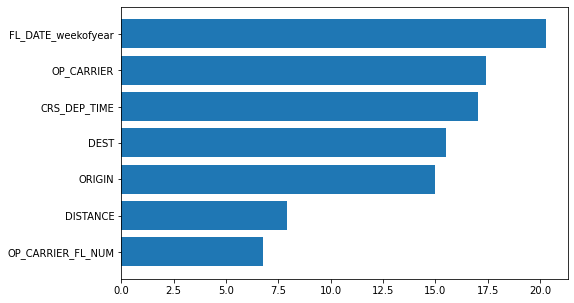

In [135]:
importances = model1.feature_importances_
indices = np.argsort(importances)

fig, ax = plt.subplots(figsize=(8, 5))

ax.barh(range(len(importances)), importances[indices])
ax.set_yticks(range(len(importances)))
_ = ax.set_yticklabels(np.array(features_train1.columns)[indices])

plt.savefig('feature_importances.png', bbox_inches='tight')